# This notebook derives from the excellent (EXCELLENT!) tutorial by Andrej Karpathy

Make sure you have read and understand the material on derivatives, partial derivatives and chain rule before working on this<Br> 

<a href="https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&ab_channel=AndrejKarpathy">Micrograd Video</a><br>
<a href="https://github.com/karpathy/micrograd">Micrograd github repo</a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
# Set random seed for reproducible results
random.seed(42)

<mark>dont worry so much about the following 2 functions.  They visualize value object chains

In [3]:
# !pip install graphviz  #install this if needed

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad), shape='record')
    # dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label,n.data), shape='record')
    
    # dot.node(name = uid, label = "{ %s }" % (n.label), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

<mark><b>Do understand the following.</b><br><br>
 Concentrate on __add__ and __mul__<br>
 Then how the closure defines a custom backward pass.<br>
 Then step through the backward fun to watch backprop in action

In [4]:
class Value:
    '''Stores a single scalar value and its gradient, as well as the operation that produced it, and a set of child Values
     eventually will also store the backward function for this node'''
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) # set of child Values
        self._op = _op 
        self.label = label # optional label for the node

        #add this after demo manual back propagation
        #function that does a piece of chain rule at each nodell
        #that has inputs and outputs.  How to chain output grads into input grads
        #by default does nothing (leaf node for instance)
        self._backward=lambda:None

    # maybe need more info on this node than value?
    # def __repr__(self):
    #     return f"Value({self.data})"
    def __repr__(self):
        return f"Label={self.label},Value=({self.data})"

    
    def __add__(self, other):
        #want to handle Value(2.0) +1 case
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # if(self is other):
            #     # if self and other are the same, then we need to double the gradient
            #     # because we are adding self to itself
            #     self.grad += 2.0 * out.grad
            # else:
            #     self.grad += 1.0 * out.grad
            #     other.grad += 1.0 * out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
    
        out._backward = _backward   #its a + node, attach the + backward function
        return out

    def __radd__(self, other):
        # this is for the case where we do 1 + Value(3.0)
        # it will call __add__ with self as Value(3.0) and other
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an integer or float"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward  # its a ** node, attach the ** backward function
        return out

    def __sub__(self, other):
        # want to handle Value(2.0) - 1 case
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward  # its a - node, attach the - backward function
        return out

    def __rsub__(self, other):
        # this is for the case where we do 1 - Value(3.0)
        # it will call __sub__ with self as Value(3.0) and other
        return self - other
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward  # its a * node, attach the * backward function
        return out

    def __rmul__(self, other):
        # this is for the case where we do 2 * Value(3.0)
        # it will call __mul__ with self as Value(3.0) and other as 2
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1.0 / other.data) * out.grad
            other.grad += (-self.data / (other.data ** 2)) * out.grad
        out._backward = _backward  # its a / node, attach the / backward function
        return out

    def tanh(self):
        out= Value(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad += (1 - math.tanh(self.data)**2) * out.grad
        out._backward = _backward  # its a tanh node, attach the tanh backward function
        return out


    def __hash__(self):
        return hash(self.__repr__())
    def __eq__(self, other):
        '''used to tell if 1 node equals another, like in seeing if n not in visited in backward(self)'''
        if isinstance(other, Value):
            return (self.data == other.data and self.label == other.label)
        return False
    # def __eq__(self, other):
    #     '''used to tell if 1 node equals another, like in seeing if n not in visited in backward(self)'''

    #     return id(self) == id(other)

    #add this after demo manual back propagation

    #fold backward function into the Value class
    #this is the function that will do the back propagation
    #it will traverse the graph in reverse order, starting from itself
    #and call the _backward function of each node
    # def backward(self):
    #     visited=[]
    #     def bwd(n):
    #         if n not in visited:
    #             # print(n)
    #             visited.append(n.label)
    #             n._backward()   
    #             for c in n._prev:
    #                 bwd(c)
    #     self.grad=1.0  #does this matter?
    #     bwd(self)

    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)  #goes from begginning to end, we want end to beginning, so reverse below
        # print(topo)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()    

# Here is the neural network


In [5]:
x1=Value(2,label='x1')
x2=Value(3,label='x2')
w1=Value(4,label='w1')
w2=Value(5,label='w2')  #if backpropgrad is 3 then thats direction of greatest increase, w2 +lr*3 (add a little it goes up, subtract a little loss goes down) 
x1w1=x1*w1; x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'
out=x1w1+x2w2; out.label='out'  #what NN predicts


### we can calculate the gradients manually

In [6]:
#do 1 at a time

out.grad=1.0
# out._backward()
# x1w1._backward()
# x2w2._backward()

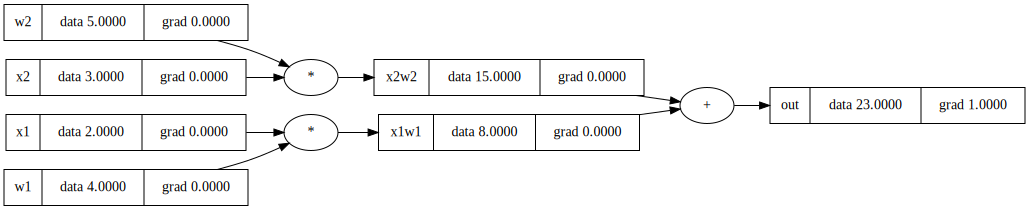

In [7]:
draw_dot(out)

# Here is the error function

This is called a lot of things; loss, objective, error function.  They all mean a function to evaluate how good your network is.<br>
<mark>IT MUST BE DIFFERENTIABLE IN ORDER FOR BACKPROP TO WORK!</mark><br>
In this case we are measuring how far apart the predicted and actual values are using Mean Squared Error (MSE)<br>

The Mean Squared Error between a predicted value $\hat{out}_i$ and the actual value $correct$ is:

$$
\text{MSE} = \frac{1}{2} \ (out - correct)^2
$$

Where:
- $correct$ = true value  
- $out$ = predicted value


<mark>You want to drive this function to 0, so move the variable of interest in the negative direction of the gradient chain to lower the output</mark><br><br>
There are a lot of error functions BTW; MSE for predicting a number, softmax or cross entropy for predicting a class, IOU for predicting how accurate a bounding box is for YOLO object detector

In [8]:
correct=Value(25,label='correct')   #what we want it to be
loss=((out-correct)**2)/2; loss.label='loss'  #and this is the mean squared loss function

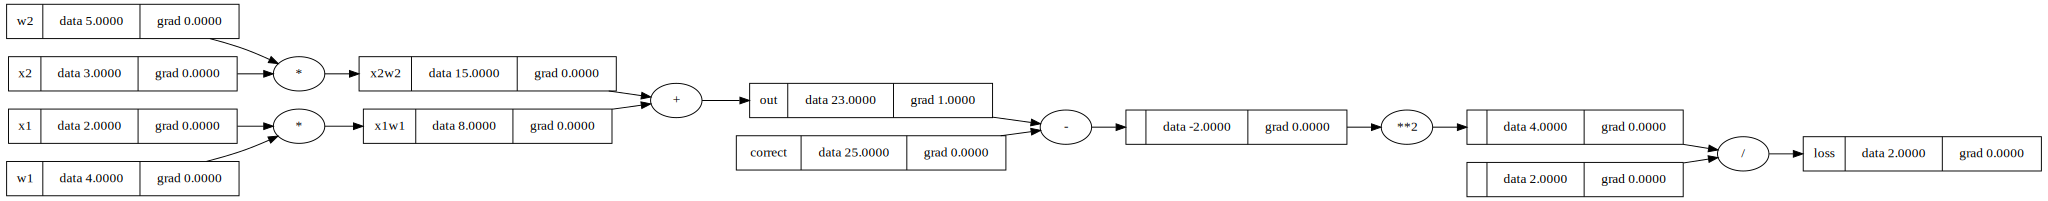

In [9]:
draw_dot(loss)  #notice how the loss is connected to the output and every other variable in a graph.

# Add one more function to the Value class called <mark>backward()</mark> to automatically calculate gradients

It will start at the output of the loss function and recursively call _backward() on each child node<br>
This will do backprop automatically!

In [10]:
#aautomatic differentiation
loss.backward()

# Start wrapping some of the equations above in classes

maybe a good time to seque to fully connected nets, and how writing equations by hand as above does not work well for large networks. 

## Lets use the valueclass to create a single neuron

It has inputs weights and a bias term (explain bias!)<br>
![](./neuron.png)

In [33]:
import random
class Neuron:
    # A simple neuron with a list of weights and a bias, using the Value class for autograd
    def __init__(self, nin):
        # nin: number of inputs to the neuron
        # Initialize weights and bias with random values between -1 and 1
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # print(list(zip(self.w,x)))
        act=sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act

    def parameters(self):
        #adjust these parameters using gradient and learning rate 
        return self.w + [self.b]


## Iteratively update parameters to get the right answer

Emphasize loss function is MSE and want to drive this to 0 so that NN predicts correct value.

<mark> point out that this is a training loop, something very like this is used when training every neural network

In [12]:
# a simple neuron with 2 inputs and 1 bias
n=Neuron(2)

#training data
xs=[[3,3]]
correct=[9]

lr=0.01  #subtract lr*grad from each weight, makes the loss go down a little bit

print(f"Initial prediction: {n(xs[0]).data}, correct={correct[0]}")
for i in range(50):
    loss=(( n(xs[0])-correct[0] )**2)/2
    loss.backward()

    if(i%10==0):
        print(f"Epoch {i}: Loss = {loss.data:.6f}")
       
    if(loss.data<0.01):
        break #early stopping
    
    for p in n.parameters():
        p.data -= lr * p.grad
        p.grad = 0.0

print(f"Final prediction: {n(xs[0]).data}, correct={correct[0]}")


Initial prediction: -2.463316041178458, correct=9
Epoch 0: Loss = 65.703807
Epoch 10: Loss = 0.971160
Epoch 20: Loss = 0.014355
Final prediction: 8.862755274654484, correct=9


Test the output of the neuron

In [13]:
#see outputs
print(n.w)
print(n.b)
print(xs[0])
# draw_dot(n(xs[0]))  


[Label=,Value=(2.0671806467841267), Label=,Value=(0.8383485603136931)]
Label=,Value=(0.14616765336102508)
[3, 3]


In [14]:
loss=(( n(xs[0])-correct[0] )**2)/2; loss.label='loss'  #and this is the mean squared loss function for the neuron

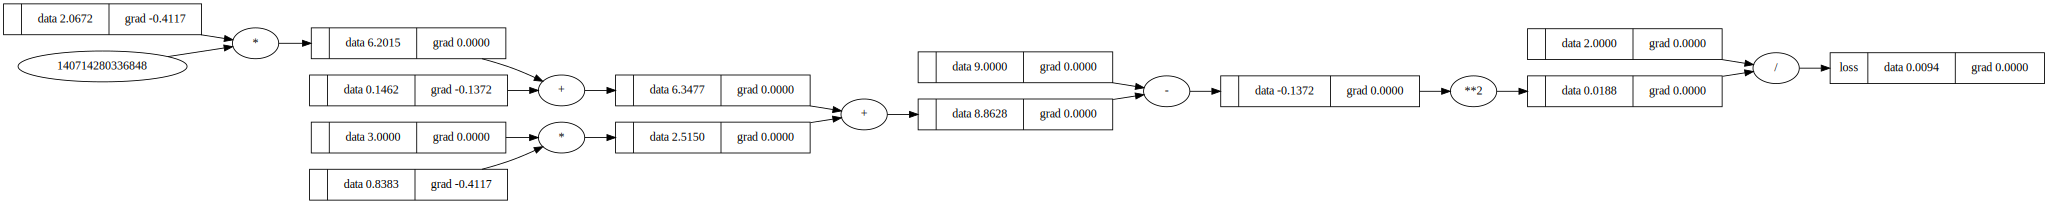

In [15]:
#and here is our entire chain (if it has been trained to predict 0 the loss will be 0 and there is no gradients to backpropagate)
draw_dot(loss)

In [16]:
loss.backward()

## Give it more than 1 value to predict



Emphasize loss function is MSE and want to drive this to 0 so that NN predicts correct value.

<mark> point out that this is a training loop, something very like this is used when training every neural network

In [17]:
def train(xs, ys, n, lr=0.01):
    """
    Trains a single neuron using mean squared error loss.

    Args:
        xs (list of list of numbers): Input data, each element is a list of input features for one example.
        ys (list of numbers): Target values corresponding to each input example.
        n (Neuron): The neuron to be trained (must implement __call__ and parameters()).
        lr (float, optional): Learning rate for parameter updates. Default is 0.01. set it to 0.1 and loss will explode
    """
    for epoch in range(500):
        # Forward pass: compute predictions for all inputs
        ypreds = [n(x) for x in xs]

        # Compute mean squared error loss
        loss = sum(((y - n(x)) ** 2)/2 for y, x in zip(correct, xs))
        if(epoch%10==0):
            print(f"Epoch {epoch}: Loss = {loss.data:.6f}")
        
        if loss.data < 0.01:  # Stop when loss is small enough (called early stopping)
            break

        # Backward pass: compute gradients
        loss.backward()

        # Update parameters using gradient descent (this is where the learning happens, in real networks this is folded into an optimizer class)
        for p in n.parameters():
            p.data -= lr * p.grad  # Update parameter by subtracting learning rate times gradient
            p.grad = 0.0  # Reset gradient after update (otherwise they add to exiting)

In [18]:
x1 = np.arange(-4, 3)
x2 = np.arange(-4, 3)
print(x1)
xs=[[x1[i], x2[i]] for i in range(len(x1))]
correct=[x1[i]*x2[i] for i in range(len(x2))]
lr=0.001
n=Neuron(2)
train(xs,correct,n,lr)

[-4 -3 -2 -1  0  1  2]
Epoch 0: Loss = 166.543534
Epoch 10: Loss = 129.188972
Epoch 20: Loss = 107.097289
Epoch 30: Loss = 93.846340
Epoch 40: Loss = 85.406459
Epoch 50: Loss = 79.905780
Epoch 60: Loss = 75.944062
Epoch 70: Loss = 73.210171
Epoch 80: Loss = 71.219265
Epoch 90: Loss = 69.694976
Epoch 100: Loss = 68.631062
Epoch 110: Loss = 67.709794
Epoch 120: Loss = 67.036792
Epoch 130: Loss = 66.418451
Epoch 140: Loss = 65.867048
Epoch 150: Loss = 65.430023
Epoch 160: Loss = 65.047833
Epoch 170: Loss = 64.693200
Epoch 180: Loss = 64.387922
Epoch 190: Loss = 64.143162
Epoch 200: Loss = 63.899660
Epoch 210: Loss = 63.698501
Epoch 220: Loss = 63.535342
Epoch 230: Loss = 63.380644
Epoch 240: Loss = 63.260089
Epoch 250: Loss = 63.160361
Epoch 260: Loss = 63.064044
Epoch 270: Loss = 62.951415
Epoch 280: Loss = 62.857000
Epoch 290: Loss = 62.732784
Epoch 300: Loss = 62.637044
Epoch 310: Loss = 62.647477
Epoch 320: Loss = 62.616425
Epoch 330: Loss = 62.509250
Epoch 340: Loss = 62.505510
Epoch

In [19]:
for x in xs:
    print(f'{x} {n(x)}')

#getting worse, give it more data

[-4, -4] Label=,Value=(6.6555196923086335)
[-3, -3] Label=,Value=(5.733681302665208)
[-2, -2] Label=,Value=(4.811842913021783)
[-1, -1] Label=,Value=(3.890004523378358)
[0, 0] Label=,Value=(2.9681661337349325)
[1, 1] Label=,Value=(2.0463277440915073)
[2, 2] Label=,Value=(1.1244893544480823)


In [20]:
#uhoh we are way off here
n([2,2])

Label=,Value=(1.1244893544480823)

# What is wrong is that the neuron is a linear function, it can only predict a line

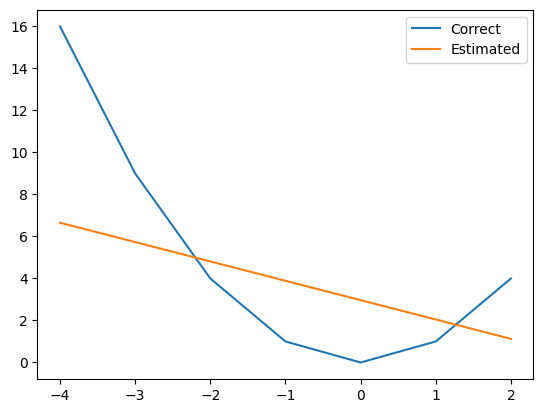

In [21]:
def plotit(n,xs,correct):
    x1 = [x[0] for x in xs]
    # correct=[x[0]*x[1] for x in xs]
    estimated=[n(x).data for x in xs]

    plt.plot(x1,correct, label='Correct')
    plt.plot(x1,estimated, label='Estimated')
    plt.legend()
    plt.show()

plotit(n,xs,correct)

# Try to add a few more neurons in a layer, and a few more layers



In [34]:
class Layer:
    """
    Represents a single layer in a neural network, consisting of multiple neurons.
    Each neuron receives the same number of inputs (nin), and the layer outputs a list of neuron outputs.
    """
    def __init__(self, nin, nout):
        # nin: number of inputs to each neuron
        # nout: number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # Forward pass: compute the output of each neuron in the layer
        outs = [n(x) for n in self.neurons]
        # If only one neuron, return its output directly
        return outs[0] if len(outs)==1 else outs
        
    def parameters(self):
        # Return all parameters (weights and biases) of all neurons in the layer
        return [p for neuron in self.neurons for p in neuron.parameters()]  # flatten the list of parameters

        #same as above but more verbose
        # params=[]
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params

class MLP:
    """
    Multi-Layer Perceptron (MLP) consisting of multiple layers.
    Each layer is a fully connected layer (Layer class).
    Args:
        nin (int): Number of inputs to the network.
        nouts (list of int): List specifying the number of outputs for each layer.
            ex [2,2,1] => 2 hidden layers with 2 neurons each and 1 output layer that has 1 neuron
    """
    def __init__(self, nin, nouts):
        '''nouts is a list of number of outputs for each layer'''
        assert isinstance(nouts, list), "nouts must be a list of integers"
        assert all(isinstance(nout, int) and nout > 0 for nout in nouts), "nouts must be a list of positive integers"
        assert nin > 0, "nin must be a positive integer"
        self.nin = nin
        sz = [nin] + nouts
        # Create each layer: input size sz[i], output size sz[i+1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        """
        Forward pass through all layers.
        Args:
            x (list): Input vector.
        Returns:
            Output of the final layer.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """
        Returns all parameters (weights and biases) of all layers.
        Returns:
            List of Value objects representing all parameters.
        """
        return [p for layer in self.layers for p in layer.parameters()]

In [35]:
n=MLP(2,[4,4,1])  # 2 inputs, 2 hidden layers of 4 neurons each, 1 output
# n=MLP(2,[16,16,1])  # 2 inputs, 2 hidden layers of 16 neurons each, 1 output
train(xs,correct,n, lr=0.0001)

Epoch 0: Loss = 529.131157
Epoch 10: Loss = 504.002051
Epoch 20: Loss = 476.405759
Epoch 30: Loss = 447.421585
Epoch 40: Loss = 419.822635
Epoch 50: Loss = 394.698398
Epoch 60: Loss = 373.722296
Epoch 70: Loss = 357.373102
Epoch 80: Loss = 344.766906
Epoch 90: Loss = 336.456786
Epoch 100: Loss = 330.359953
Epoch 110: Loss = 326.879666
Epoch 120: Loss = 323.345812
Epoch 130: Loss = 322.233193
Epoch 140: Loss = 321.120415
Epoch 150: Loss = 320.280413
Epoch 160: Loss = 319.154506
Epoch 170: Loss = 318.282765
Epoch 180: Loss = 318.781930
Epoch 190: Loss = 317.562746
Epoch 200: Loss = 318.392433
Epoch 210: Loss = 318.090900
Epoch 220: Loss = 318.373535
Epoch 230: Loss = 316.534297
Epoch 240: Loss = 318.030468
Epoch 250: Loss = 316.741363
Epoch 260: Loss = 318.052458
Epoch 270: Loss = 318.293113
Epoch 280: Loss = 318.345858
Epoch 290: Loss = 316.171956
Epoch 300: Loss = 317.977684
Epoch 310: Loss = 317.435352
Epoch 320: Loss = 318.211669
Epoch 330: Loss = 317.264691
Epoch 340: Loss = 318.200

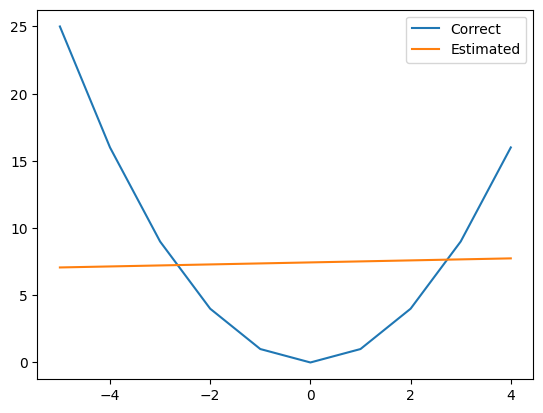

In [36]:
plotit(n,xs,correct)

In [25]:
#back to same problem, linear collapse
#needs a non linearity to plot non linear functions

## Add an activation function to make network non-linear

Problem is that last layer smashes output between -1 and 1 <br>
The solution is add a use_activation member var and make sure the last layer does not use one

Show tanh, sigmoid relu, leaky relu examples
They should always be between layers but not necessarily on last layer

In [38]:
# import random
class Neuron:
    def __init__(self, nin, use_activation=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.use_activation = use_activation

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        if self.use_activation:
            out = act.tanh()
        else:
            out = act  # Linear activation (no activation function)
        return out

    def parameters(self):
        #adjust these parameters using gradient and learning rate 
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout, use_activation=True):
        self.neurons = [Neuron(nin, use_activation) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        assert isinstance(nouts, list), "nouts must be a list of integers"
        assert all(isinstance(nout, int) and nout > 0 for nout in nouts), "nouts must be a list of positive integers"
        assert nin > 0, "nin must be a positive integer"
        self.nin = nin
        sz = [nin] + nouts
        # Create layers: all hidden layers use tanh, final layer is linear
        self.layers = []
        for i in range(len(sz)-1):
            is_final_layer = (i == len(sz)-2)
            use_activation = not is_final_layer  # No activation for final layer
            self.layers.append(Layer(sz[i], sz[i+1], use_activation))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [40]:
n=MLP(2,[4,4,1])  # 2 inputs, 2 hidden layers of 4 neurons each, 1 output
# n=MLP(2,[16,16,1])  # 2 inputs, 2 hidden layers of 16 neurons each, 1 output
train(xs,correct,n, lr=0.001)

Epoch 0: Loss = 619.500400
Epoch 10: Loss = 527.191441
Epoch 20: Loss = 452.217386
Epoch 30: Loss = 390.940570
Epoch 40: Loss = 352.756746
Epoch 50: Loss = 333.291923
Epoch 60: Loss = 322.509662
Epoch 70: Loss = 316.462650
Epoch 80: Loss = 312.516620
Epoch 90: Loss = 309.880118
Epoch 100: Loss = 307.605634
Epoch 110: Loss = 305.250668
Epoch 120: Loss = 302.197946
Epoch 130: Loss = 297.361974
Epoch 140: Loss = 288.537275
Epoch 150: Loss = 273.179869
Epoch 160: Loss = 254.373956
Epoch 170: Loss = 235.675757
Epoch 180: Loss = 217.012953
Epoch 190: Loss = 198.899685
Epoch 200: Loss = 181.791212
Epoch 210: Loss = 166.116076
Epoch 220: Loss = 152.082733
Epoch 230: Loss = 139.721942
Epoch 240: Loss = 128.938407
Epoch 250: Loss = 119.569065
Epoch 260: Loss = 111.451272
Epoch 270: Loss = 104.352394
Epoch 280: Loss = 98.123569
Epoch 290: Loss = 92.609979
Epoch 300: Loss = 87.691196
Epoch 310: Loss = 83.286468
Epoch 320: Loss = 79.295913
Epoch 330: Loss = 75.448902
Epoch 340: Loss = 75.804550
Epo

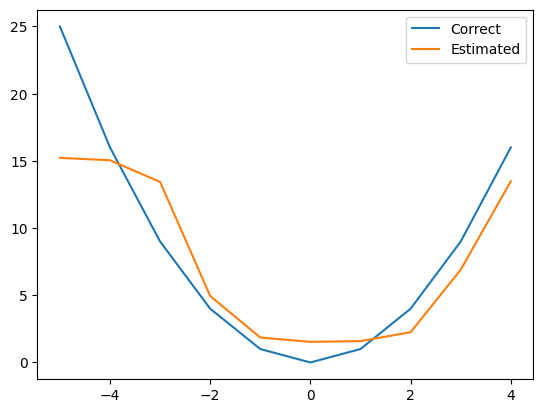

In [41]:
plotit(n,xs,correct)

## BTW when training you care about the number of trainable parameters (the weights and biases) 



In [43]:
print(f'Number trainable parameters={len(n.parameters())}')
print(f'Number trainable parameters={n.parameters()}')

Number trainable parameters=37
Number trainable parameters=[Label=,Value=(-0.31691668921912114), Label=,Value=(-0.37439408278880065), Label=,Value=(2.106602776108954), Label=,Value=(0.020675968651909793), Label=,Value=(0.8571126880686575), Label=,Value=(2.130628195431121), Label=,Value=(-0.9650883170889935), Label=,Value=(0.9322999606866973), Label=,Value=(1.481812632170018), Label=,Value=(0.45338653820782826), Label=,Value=(0.36812798965458127), Label=,Value=(1.1092544261087511), Label=,Value=(-0.4176629416990797), Label=,Value=(-0.0737525723876266), Label=,Value=(-0.9077726289089915), Label=,Value=(-0.33952035922809787), Label=,Value=(-1.2778668981483539), Label=,Value=(1.7476559342786464), Label=,Value=(1.5302065848919604), Label=,Value=(-0.9449225506820463), Label=,Value=(0.24365073672840248), Label=,Value=(-0.7706689452342967), Label=,Value=(0.08551148312878176), Label=,Value=(0.5827151019273857), Label=,Value=(1.4466966892259125), Label=,Value=(-0.32751191572187627), Label=,Value

# Non linear approximation

But what happens to predictions outside training data?  <br>


[-5 -4 -3 -2 -1  0  1  2  3  4]


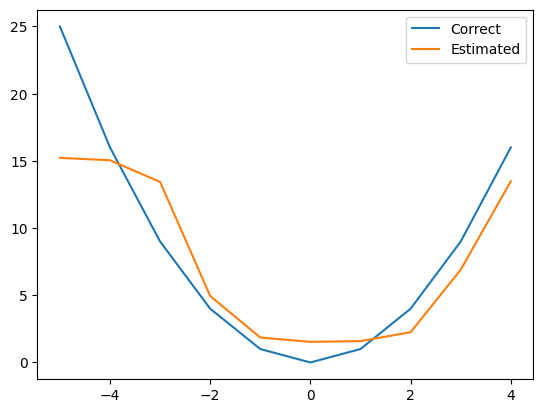

In [44]:
x1 = np.arange(-5, 5)
x2 = np.arange(-5, 5)
print(x1)
xs=[[x1[i], x2[i]] for i in range(len(x1))]
correct=[x1[i]*x2[i] for i in range(len(x2))]
plotit(n,xs,correct)